# Unsupervised Learning

Anthony Villalba

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from warnings import simplefilter
simplefilter(action="ignore")

raw_data = pd.read_csv("Customer Churn.csv")

### Data Cleaning

In [246]:
styled_data = (
    raw_data.head()
    .style.set_table_styles([
        {'selector': 'thead th', 'props': [('background-color', '#0014a8'), ('color', 'white'), 
                                           ('font-size', '14px'), ('border', '1px solid white')]},
        {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('padding', '8px'), 
                                           ('color', '#ffffff')]},  
        {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#000000')]},  
        {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#0014a8')]}  
    ])
    .applymap_index(lambda v: 'color: #ffffff;', axis='index')  
)

# Display the styled table
display(styled_data)

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640000,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035000,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520000,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020000,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805000,0


This dataset pertains to an Iranian telecom company and contains detailed information about its customers and their activities. It also indicates whether customers churned (left the company by the end of the year) or not. By analyzing this data, we can identify key customer groups that may require greater attention or improved experiences to reduce churn and enhance customer retention.

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call  Failure            3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription  Length     3150 non-null   int64  
 3   Charge  Amount           3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int64  
 10  Status                   3150 non-null   int64  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  Churn                    3150 non-null   int64  
dtypes: float64(1), int64(13)

None of the variables have missing data. We should drop categorial variables since this is not great for k-means because it relies on distance calculations and binary/categorial variable could cause problems/unacurate results, here are the following categorial variables that will be dropped.

In [7]:
# Categorial/binary variables so we will drop these
print(raw_data['Age Group'].value_counts())
print(raw_data['Tariff Plan'].value_counts())
print(raw_data['Status'].value_counts())
print(raw_data['Churn'].value_counts())
print(raw_data['Complains'].value_counts())

Age Group
3    1425
2    1037
4     395
5     170
1     123
Name: count, dtype: int64
Tariff Plan
1    2905
2     245
Name: count, dtype: int64
Status
1    2368
2     782
Name: count, dtype: int64
Churn
0    2655
1     495
Name: count, dtype: int64
Complains
0    2909
1     241
Name: count, dtype: int64


In [9]:
data = raw_data.drop(columns=['Age Group', 'Tariff Plan', 'Status', 'Complains', 'Churn'])
data.head()

,Call Failure,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age,Customer Value
0,8,38,0,4370,71,5,17,30,197.640
1,0,39,0,318,5,7,4,25,46.035
2,10,37,0,2453,60,359,24,30,1536.520
3,10,38,0,4198,66,1,35,15,240.020
4,3,38,0,2393,58,2,33,15,145.805


Next, we will remove large outliers that are more than 3 standard deviations away from the mean to minimize their impact on skewing the clustering results.

In [12]:
# Calculate Z-scores for each feature
z_scores = np.abs((data - data.mean()) / data.std())

# Identify rows where any Z-score is greater than 3 (considered an outlier)
outliers = (z_scores > 3).any(axis=1)

# Remove these outliers
filtered_data = data[~outliers]

We will standardize the data to ensure all features have a mean of 0 and a standard deviation of 1. This is needed because k-means clustering is a distance-based calculation that can be disproportionately influenced by features with larger scales.

In [14]:
# Instantiate the scaler
scaler = StandardScaler()

# Fit and transform the data
sd_data = scaler.fit_transform(filtered_data)

# Convert back to a DataFrame
sd_data = pd.DataFrame(sd_data, columns=data.columns)

sd_data.head()

,Call Failure,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age,Customer Value
0,0.161766,0.650756,-0.688915,0.069099,0.096827,-0.627902,-0.341344,-0.083370,-0.490795
1,-1.100524,0.769846,-0.688915,-0.980125,-1.152535,-0.606658,-1.194807,-0.666157,-0.819559
2,0.477339,0.531666,-0.688915,-0.427289,-0.111400,3.132264,0.118213,-0.083370,2.412640
3,0.477339,0.650756,-0.688915,0.024562,0.002178,-0.670390,0.840373,-1.831731,-0.398892
4,-0.627165,0.650756,-0.688915,-0.442825,-0.149260,-0.659768,0.709071,-1.831731,-0.603202


# K-means Clustering

Before we begin with k-means clusteirng, we need to determine the optimal number of clusters, to this end I will use the elbow plot and the silhouette score.

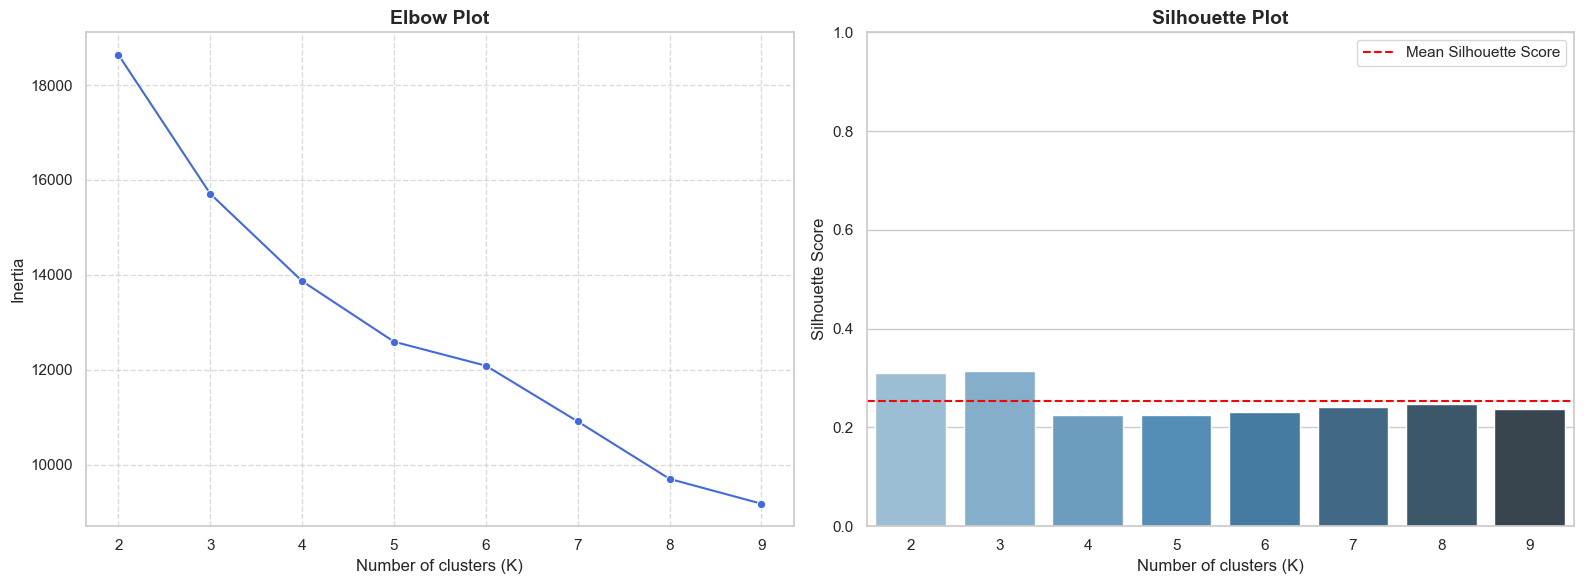

In [18]:
# Define range of K to test
k_range = range(2, 10)

# Create empty lists for storing the resulting values
inertias = []
silhouette_scores = []

# Run a loop to fit KMeans for each value of K
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(sd_data)
    
    # Append the inertia (sum of squared distances to the nearest cluster center)
    inertias.append(kmeans.inertia_)
    
    # Calculate and append the silhouette score
    labels = kmeans.labels_
    score = silhouette_score(sd_data, labels)
    silhouette_scores.append(score)

sns.set_theme(style="whitegrid")

# Create the subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Elbow Plot
sns.lineplot(x=k_range, y=inertias, marker='o', color="royalblue", ax=ax[0])
ax[0].set_xlabel('Number of clusters (K)', fontsize=12)
ax[0].set_ylabel('Inertia', fontsize=12)
ax[0].set_title('Elbow Plot', fontsize=14, fontweight='bold')
ax[0].grid(visible=True, linestyle='--', alpha=0.7)

# Silhouette Score Plot
sns.barplot(x=list(k_range), y=silhouette_scores, palette="Blues_d", ax=ax[1])
ax[1].axhline(y=np.mean(silhouette_scores), color='red', linestyle='--', label='Mean Silhouette Score')
ax[1].set_ylim([0, 1])
ax[1].set_xlabel('Number of clusters (K)', fontsize=12)
ax[1].set_ylabel('Silhouette Score', fontsize=12)
ax[1].set_title('Silhouette Plot', fontsize=14, fontweight='bold')
ax[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

Based on both the Elbow plot and the Silhouette Score, 3 clusters is the optimal number of clusters for K-means clustering. The Elbow plot shows a 'elbow' at 3 clusters, you can possibly argue 5, and the Silhouette score indicates that 3 clusters yields the highest score. Therefore, we will proceed with 3 clusters for the K-means analysis, taking both factors into account.

## Cluster Profiling & Analysis

In [20]:
# Initialize KMeans with 3 clusters
k = 3
kmeans = KMeans(n_clusters = k, n_init=100, random_state=42)

# Fit the model on the standardized data
kmeans.fit(sd_data)

# Get the cluster labels for each observation
cluster_labels = kmeans.labels_

# Add the cluster labels back to the original data for profiling
filtered_data['Cluster'] = cluster_labels

### Centroid Analysis (Mean)

I will calculate the mean of each feature for every cluster, which represents the centroid of the cluster. This helps to understand the central tendency of each feature within each cluster and in general what type of customers belong to each cluster

In [22]:
# Compute the mean of each feature for each cluster
cluster_profile = filtered_data.groupby('Cluster').mean()

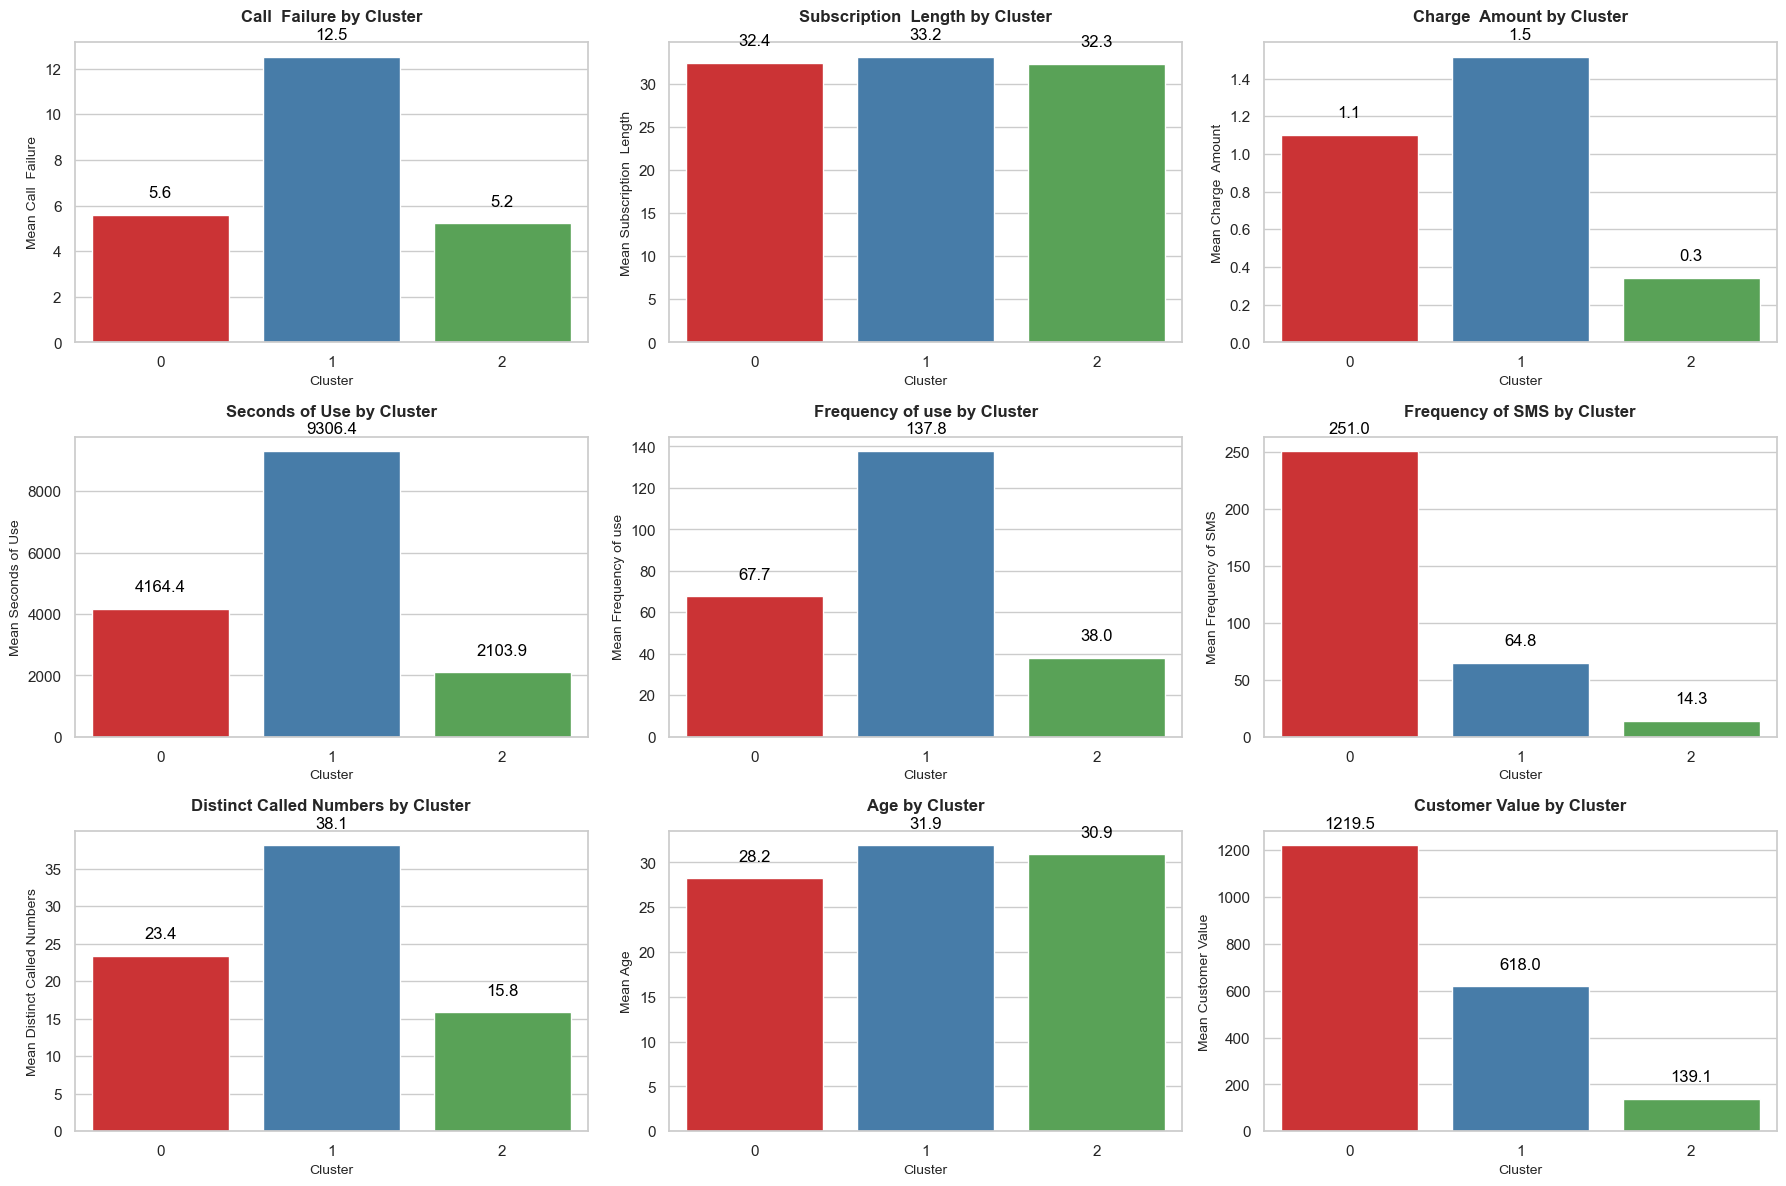

         Call  Failure  Subscription  Length  Charge  Amount  Seconds of Use  \
Cluster                                                                        
0             5.603004             32.407725        1.100858     4164.429185   
1            12.529851             33.164179        1.516418     9306.405970   
2             5.221274             32.329920        0.343003     2103.861206   

         Frequency of use  Frequency of SMS  Distinct Called Numbers  \
Cluster                                                                
0               67.710300        251.025751                23.392704   
1              137.756716         64.788060                38.082090   
2               38.009670         14.311149                15.829920   

               Age  Customer Value  
Cluster                             
0        28.229614     1219.474013  
1        31.895522      618.027037  
2        30.924346      139.134084  


In [28]:
# Set up the plotting environment
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

# Plotting means for each cluster
for idx, (column, ax) in enumerate(zip(cluster_profile.columns, axes.flatten())):  # Include all columns in cluster_profile
    sns.barplot(x=cluster_profile.index, y=cluster_profile[column], palette='Set1', ax=ax)
    
    # Annotating the plot with mean values
    for i, val in enumerate(cluster_profile[column]):
        ax.text(i, val + (0.05 * max(cluster_profile[column])),
                f'{val:.1f}', ha='center', va='bottom', fontsize=12, color='black')
    
    # Titles and labels
    ax.set_title(f'{column} by Cluster', fontsize=12, fontweight='bold', pad=15)
    ax.set_xlabel('Cluster', fontsize=10)
    ax.set_ylabel(f'Mean {column}', fontsize=10)
    ax.set_xticks(cluster_profile.index)

# Adjust layout and show the plot
plt.tight_layout(pad=1.0)
plt.show()

# Display the cluster profile
print(cluster_profile)

**Cluster Interpretations:**
- Each CLuster represents different types of customers
- **Cluster 0:**
  - Customers with moderate usage, but they have the highest frequency of SMS. 
  - They are the youngest group, with the highest customer value and moderate spending. 
  - These customers are likely to have the lowest churn rate due to their high value.

- **Cluster 1:**
  - Customers with high usage, characterized by the highest seconds of use and frequency of use. 
  - They have the second highest frequency of SMS. 
  - This cluster is also the oldest group with moderate customer value and high spending. 
  - Efforts to retain these customers would be beneficial as they generate significant revenue.

- **Cluster 2:**
  - Represents customers with low usage (low seconds and frequency of use) and minimal spending. These may be casual users or those who use the service occasionally. 
  - They also have the lowest customer value, suggesting a higher likelihood of churn. 
  - Improving their experience could help retain these customers.
- We also see that the subsribtion length for each group of customers (clusters) is very similar

### Within Cluster variance analysis

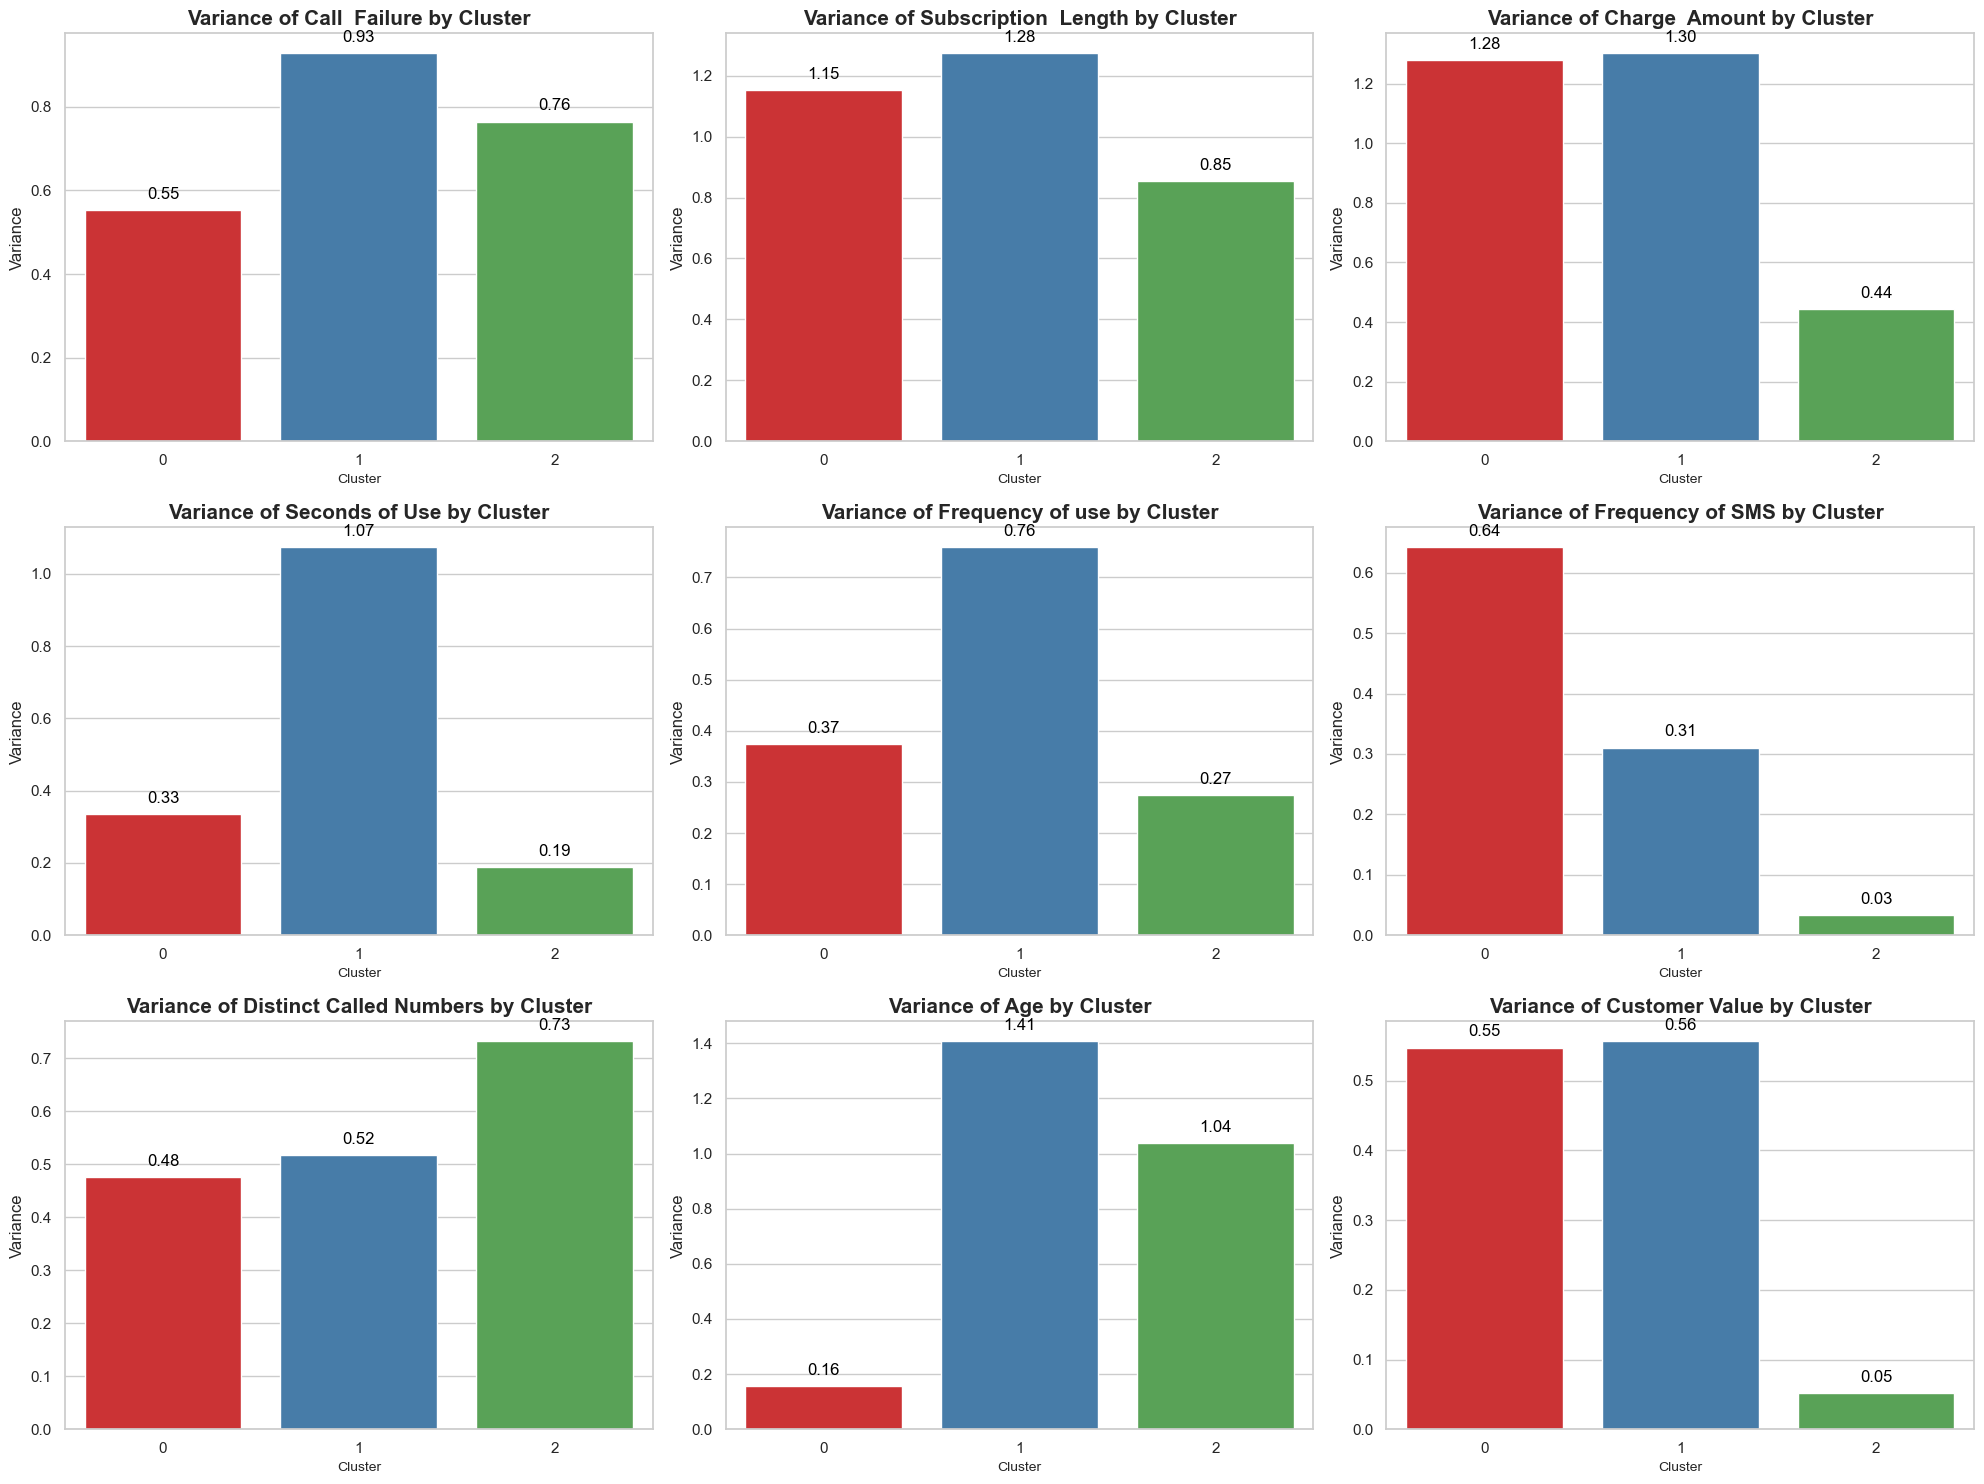

         Call  Failure  Subscription  Length  Charge  Amount  Seconds of Use  \
Cluster                                                                        
0             0.553482              1.152908        1.279310        0.334360   
1             0.929355              1.275269        1.303654        1.074510   
2             0.764791              0.853629        0.443052        0.189043   

         Frequency of use  Frequency of SMS  Distinct Called Numbers  \
Cluster                                                                
0                0.373295          0.642976                 0.475321   
1                0.759909          0.310608                 0.517596   
2                0.274232          0.033238                 0.733057   

              Age  Customer Value  
Cluster                            
0        0.156729        0.547405  
1        1.409182        0.557091  
2        1.039009        0.051556  


In [38]:
sd_data['Cluster'] = cluster_labels

# Compute the variance of each feature for each cluster based on standardized data
cluster_variance = sd_data.groupby('Cluster').var()

# Set up the plotting environment
fig, axes = plt.subplots(3, len(cluster_variance.columns) // 3, figsize=(20, 15))

# Plotting the variance for each feature within each cluster
for idx, (column, ax) in enumerate(zip(cluster_variance.columns, axes.flatten())):  # Flatten axes for easy indexing
    sns.barplot(x=cluster_variance.index, y=cluster_variance[column], palette='Set1', ax=ax)
    
    # Get the current y-axis limits
    y_max = ax.get_ylim()[1]
    
    # Annotating the plot with variance values
    for i, val in enumerate(cluster_variance[column]):
        ax.text(i, val + (0.02 * y_max),  # Position slightly above the bar
                f'{val:.2f}', ha='center', va='bottom', fontsize=12, color='black')
    
    # Titles and labels
    ax.set_title(f'Variance of {column} by Cluster', fontsize=15, fontweight='bold')
    ax.set_xlabel('Cluster', fontsize=10)
    ax.set_ylabel(f'Variance', fontsize=12)
    ax.set_xticks(cluster_variance.index)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

print(cluster_variance)

From the variances, we observe that Cluster 2 generally has the least variation across variables, indicating a more homogeneous group. On the other hand, Cluster 1 exhibits the highest variation, suggesting a more diverse or spread-out set of feature values within this cluster.

# Supervised Learning

In [248]:
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import make_scorer, f1_score, mean_absolute_error, mean_squared_error, r2_score

### Data Cleaning

In [251]:
raw_data = pd.read_csv("car_prices.csv", on_bad_lines="skip")
raw_data = raw_data.dropna(axis=0)

In [253]:
styled_data = (
    raw_data.head()
    .style.set_table_styles([
        {'selector': 'thead th', 'props': [('background-color', '#7a0000'), ('color', 'white'), 
                                           ('font-size', '14px'), ('border', '1px solid white')]},
        {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('padding', '8px'), 
                                           ('color', '#ffffff'), ('line-height', '.85')]},  
        {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#000000')]},  
        {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#7a0000')]} 
    ])
    .applymap_index(lambda v: 'color: #ffffff;', axis='index')      
)
# Display the styled table
display(styled_data)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.000000,16639.000000,white,black,"kia motors america, inc",20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.000000,9393.000000,white,beige,"kia motors america, inc",20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,4.500000,1331.000000,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,4.100000,14282.000000,white,black,volvo na rep/world omni,27500,27750,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,4.300000,2641.000000,gray,black,financial services remarketing (lease),66000,67000,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


This dataset contains information on car auctions. The variable I will try to predict is 'sellingprice', which represents the final selling price of each car at auction, using a Random Forest model

I will use a sample of 20,000 rows to reduce the computational resources and time required for training the model

In [228]:
# Sample 20,000 rows from the dataset
sample_df = raw_data.sample(n=20000, random_state=42)

There are some variables that can be dropped as they do not provide any significant value or relevance in predicting the selling price. Specifically, 'vin' (vehicle identification number), 'saledate' (date of sale), and 'seller' (information about the seller) are dropped from the dataset.

In [231]:
sample_df = sample_df.drop(['vin', 'saledate', 'seller'], axis=1)

Next, we apply one-hot encoding to all the categorical columns by creating binary columns for each category. We also remove one category per column to avoid the dummy variable trap (perfect multicollinearity).

In [234]:
categorical_cols = ['state', 'make', 'model', 'trim', 'body', 'transmission', 'color', 'interior']
sample_df = pd.get_dummies(sample_df, columns = categorical_cols, drop_first = True)

In [236]:
sample_df.head()

,year,condition,odometer,mmr,sellingprice,state_az,state_ca,state_co,state_fl,state_ga,...,interior_gray,interior_green,interior_off-white,interior_orange,interior_purple,interior_red,interior_silver,interior_tan,interior_white,interior_—
290593,1996,2.0,214227.0,725,800,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
264473,2011,2.8,31307.0,10750,10800,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13849,2009,4.4,69251.0,10950,11900,False,False,False,False,True,...,True,False,False,False,False,False,False,False,False,False
492355,2012,1.9,45617.0,12550,11800,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
191166,2006,2.6,136495.0,3275,2600,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


### Training Random Forest Model & Evaluating Performance

Now seperate target variable from the rest of the features and split into training, validation and test set.

In [240]:
X = sample_df.drop('sellingprice', axis=1)  # Drop target variable from df
y = sample_df['sellingprice']  # Target variable

In [242]:
# Split into 70% train and 30% temp 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temp set into 50% validation and 50% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Now, we train the Random Forest model on the training set. Hyperparameters are chosen after experimenting with multiple configurations to identify the best options that minimize error.

In [258]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=125, random_state = 42,
                                 max_depth=10, min_samples_split=9, min_samples_leaf=5)

# Train the model using the training set
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=9,
                      n_estimators=125, random_state=42)

Now we can assess performance on the validation and test sets.

In [261]:
# Predict on the validation set
y_val_pred = rf_model.predict(X_val)

# Evaluate on the validation set
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, y_val_pred)

print("Validation Set Performance:")
print(f"Mean Absolute Error: {val_mae:.2f}")
print(f"Root Mean Squared Error: {val_rmse:.2f}")
print(f"R^2 Score: {val_r2:.4f}")

Validation Set Performance:
Mean Absolute Error: 957.16
Root Mean Squared Error: 1595.79
R^2 Score: 0.9708


The Mean Absolute Error of 957.13 indicates that, on average, the predicted selling prices deviate by around $957 from the actual values. The Root Mean Squared Error of 1594.57 suggests that the predictions are off by approximately 1595 on average when squared. The R^2 Score of 0.9709 indicates that about 97.09% of the variance in the actual selling prices is explained by the model, showing a very strong predictive performance.

In [264]:
# Predict on the test set
y_test_pred = rf_model.predict(X_test)

# Evaluate on the test set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print("Test Set Performance:")
print(f"Mean Absolute Error: {test_mae:.2f}")
print(f"Root Mean Squared Error: {test_rmse:.2f}")
print(f"R^2 Score: {test_r2:.4f}")

Test Set Performance:
Mean Absolute Error: 995.35
Root Mean Squared Error: 1904.28
R^2 Score: 0.9646


The Mean Absolute Error of 995.35 indicates that, on average, the predicted selling prices deviate by around 995 from the actual values. The Root Mean Squared Error of 1904.28 suggests that the predictions are off by approximately 1902 on average when squared. The R^2 Score of 0.9646 indicates that about 96.46% of the variance in the actual selling prices is explained by the model, demonstrating a strong predictive performance. Overall we see that the model does well in predicting selling price.

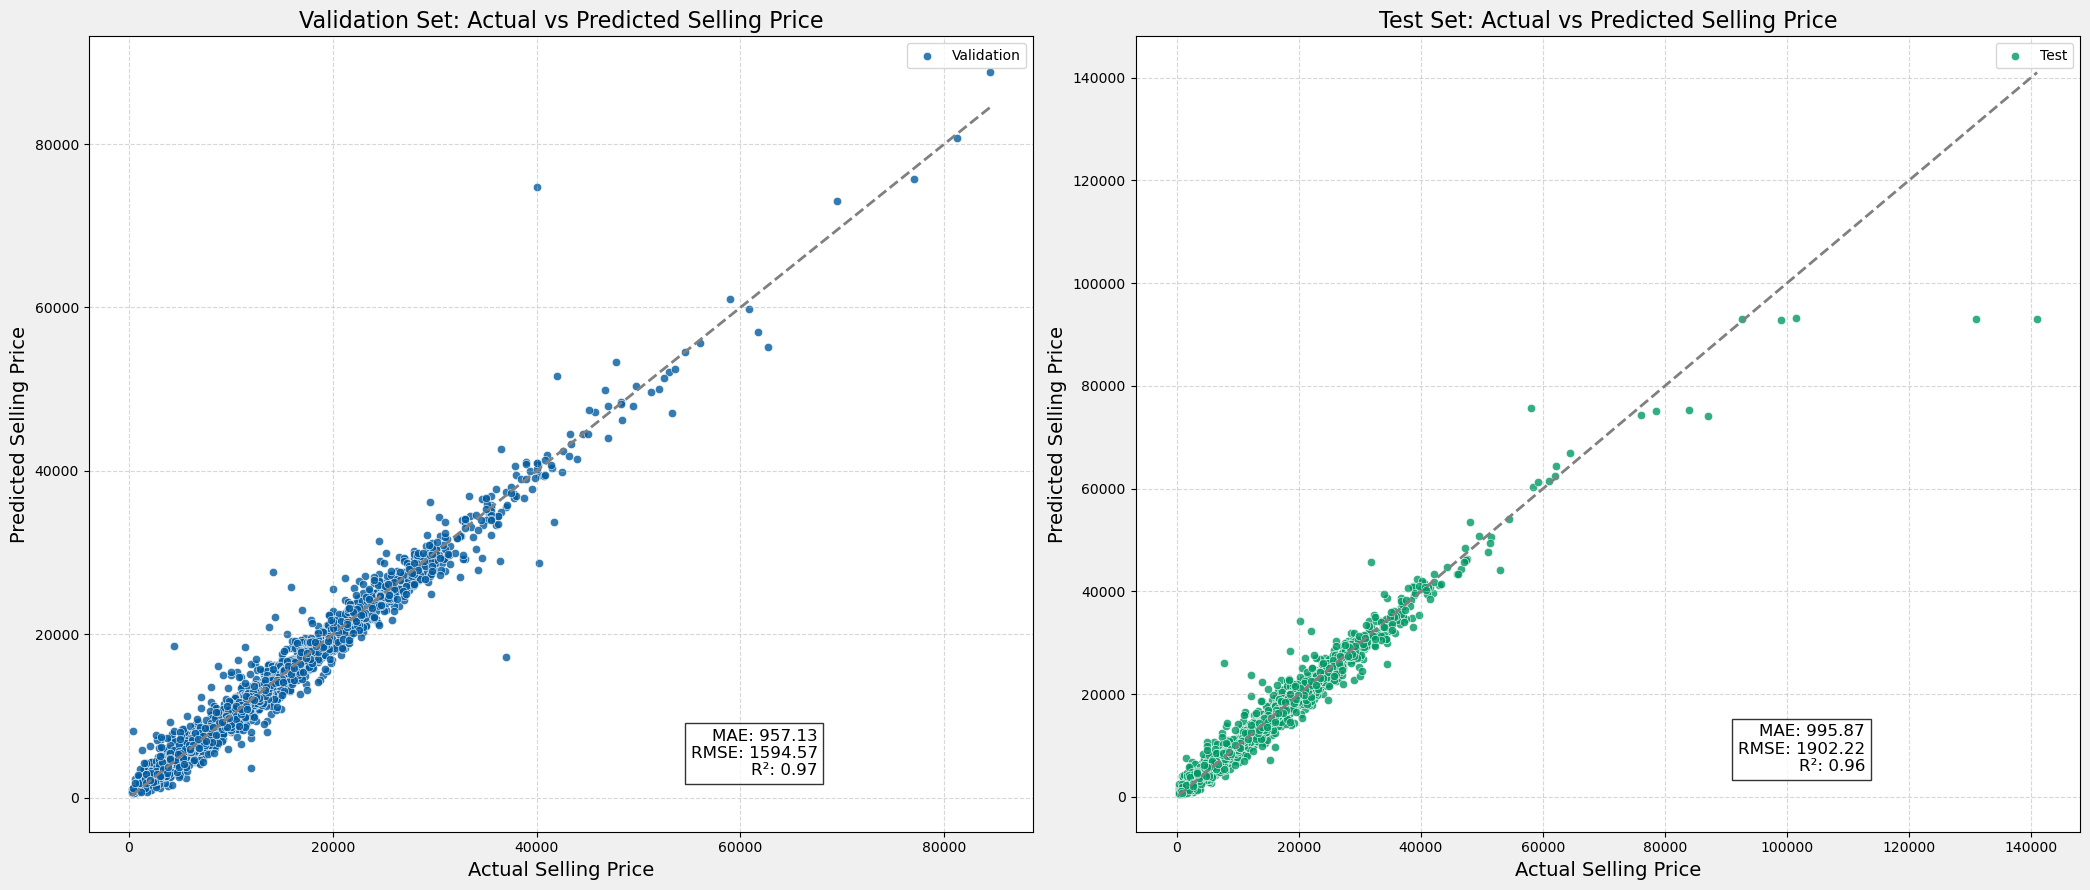

In [227]:
# Side-by-side scatter plots for validation and test sets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 9))
fig.patch.set_facecolor('#F0F0F0')  # Light gray background color for the figure

# Validation set scatter plot
sns.scatterplot(x=y_val, y=val_predictions, ax=ax1, label='Validation', alpha=0.8, color='#005A9E')  # Darker blue for distinction
ax1.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2, color='gray')  # Diagonal line
ax1.set_xlabel('Actual Selling Price', fontsize=14)
ax1.set_ylabel('Predicted Selling Price', fontsize=14)
ax1.set_title('Validation Set: Actual vs Predicted Selling Price', fontsize=16)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.5)  # Light grid for better contrast
# Text annotations
ax1.text(y_val.max()*0.8, y_val.max()*0.1, f'MAE: {val_mae:.2f}\nRMSE: {val_rmse:.2f}\nR²: {val_r2:.2f}', 
         horizontalalignment='right', verticalalignment='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Test set scatter plot
sns.scatterplot(x=y_test, y=test_predictions, ax=ax2, label='Test', alpha=0.8, color='#009966')  # Darker green for distinction
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='gray')  # Diagonal line
ax2.set_xlabel('Actual Selling Price', fontsize=14)
ax2.set_ylabel('Predicted Selling Price', fontsize=14)
ax2.set_title('Test Set: Actual vs Predicted Selling Price', fontsize=16)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.5)  # Light grid for better contrast
# Text annotations
ax2.text(y_test.max()*0.8, y_test.max()*0.1, f'MAE: {test_mae:.2f}\nRMSE: {test_rmse:.2f}\nR²: {test_r2:.2f}', 
         horizontalalignment='right', verticalalignment='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

While the model generally performs well and captures the overall trend in selling prices, it appears to somewhat struggle with higher-priced vehicles. This could be due to fewer observations at higher selling prices, limiting the amount of data the random forest model had to learn from.

# Natural Language Processing

In [72]:
# Data processing and model selection
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_sample_weight

# Text preprocessing utilities
import re
from langdetect import detect
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Downloading required NLTK data
import nltk
from nltk.stem import PorterStemmer

#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt')

### Preparing Datasets

In [12]:
data1 = pd.read_csv("7282_1.csv")
data2 = pd.read_csv("Datafiniti_Hotel_Reviews.csv")
data3 = pd.read_csv("Datafiniti_Hotel_Reviews_Jun19.csv")

There are three datasets, each containing hotel reviews and additional information about customers and the ratings they provided. To work with this data, I will combine the 3 datasets into a single dataset. After combining them, I will remove any duplicate rows to retain only unique observations.

In [15]:
# Align columns by identifying the union of all columns
all_columns = set(data1.columns).union(data2.columns).union(data3.columns)

# Reindex each dataset to ensure all have the same columns
data1 = data1.reindex(columns = all_columns)
data2 = data2.reindex(columns = all_columns)
data3 = data3.reindex(columns = all_columns)

# Concatenate datasets
combined_data = pd.concat([data1, data2, data3], ignore_index=True)

# Remove duplicate rows from the dataset, keeping only the first occurrence of each duplicate
combined_data = combined_data.drop_duplicates()

To perform Naive Bayes classification, we need a target variable and a text variable to predict the target. I will use "reviews.rating" as the target variable and "reviews.text" as the text variable. Therefore, I will clean these two columns by dropping any rows with missing values in either of them.

In [18]:
# Drop rows with NaN in 'reviews.text' or 'reviews.rating'
combined_data = combined_data.dropna(subset=['reviews.text', 'reviews.rating'])

# Get final counts
final_counts = combined_data[['reviews.text', 'reviews.rating']].count()
print("Final counts:")
print(final_counts)

Final counts:
reviews.text      54811
reviews.rating    54811
dtype: int64


Most reviews have integer ratings between 0 and 5, but there are a few outliers with decimal ratings or values greater than 5, such as 5.1. To maintain a consistent scale across all reviews, I will only keep those with integer ratings from 0 to 5.

In [21]:
combined_data['reviews.rating'].value_counts()

reviews.rating
5.00    21767
4.00    14950
3.00     8058
1.00     4192
2.00     4076
        ...  
1.30        1
2.80        1
1.50        1
9.50        1
4.75        1
Name: count, Length: 62, dtype: int64

In [23]:
# Check if the rating is an integer and within the range 0-5
filtered_data = combined_data[
    (np.modf(combined_data['reviews.rating'])[0] == 0) &  # Integer check
    (combined_data['reviews.rating'] >= 0) &
    (combined_data['reviews.rating'] <= 5)
]
print(filtered_data['reviews.rating'].value_counts())
# Get final counts
final_counts = filtered_data[['reviews.text', 'reviews.rating']].count()
print("Final counts:")
print(final_counts)

reviews.rating
5.0    21767
4.0    14950
3.0     8058
1.0     4192
2.0     4076
0.0      337
Name: count, dtype: int64
Final counts:
reviews.text      53380
reviews.rating    53380
dtype: int64


Now we only have integer ratings and the accompanying review both with 53,380 observations.

### Text Pre-processing & Cleaning

First, we need to clean and preprocess the text to prepare it for Naive Bayes classification. The clean_text function removes URLs, HTML tags, special characters, and punctuation, and converts the text to lowercase. The preprocess_text function first cleans the text using clean_text, then tokenizes the text, removes stopwords for English, Spanish & French, and words less than 2 characters, applies lemmatization, stemming and returns the processed text as a single string. It also handles negations so it can understand that 'not good' is negative etc. Also 'hotel' and 'room' will be dropped since these are very common in all reviews and will add noise.

In [28]:
def clean_text(text, language='en'):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Handle negations for English
    if language == 'en':
        text = re.sub(r'\b(not|no|never)\s+(\w+)', r'\1_\2', text)
    
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

domain_stopwords = {'hotel', 'room'}

def preprocess_text(text_data):
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    
    # Detect language
    try:
        language = detect(text_data)
        if language == 'en':
            stop_words = set(stopwords.words('english'))
        elif language == 'es':
            stop_words = set(stopwords.words('spanish'))
        elif language == 'fr':
            stop_words = set(stopwords.words('french'))
        else:
            stop_words = set()  # Fallback for other languages
    except:
        language = 'unknown'
        stop_words = set()  # Fallback if language detection fails

    # Add domain-specific stopwords
    stop_words = stop_words.union(domain_stopwords)
    
    # Clean text based on detected language
    cleaned_text = clean_text(text_data, language=language)
    
    # Tokenize and filter stopwords
    tokens = cleaned_text.split()
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens 
                       if token not in stop_words and (len(token) > 2 or token in {'no', 'not'})]
    
    # Apply stemming
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    
    return ' '.join(stemmed_tokens)

There are 54,811 reviews to speed up the process I will work with a sample of size 18,000 and apply the preprocess_text function to it.

In [31]:
# Sample 18,000 rows from the dataset
sample_df = filtered_data.sample(n=18000, random_state=42)

In [33]:
# Apply the text preprocessing function to the 'reviews.text' column
sample_df['cleaned_text'] = sample_df['reviews.text'].apply(preprocess_text)

In [35]:
# Display original and cleaned text side by side
sample_df[['reviews.text', 'cleaned_text']].head(6)

,reviews.text,cleaned_text
51527,Stayed here because even though we were going ...,stay even though go somewher pensacola prefer ...
32297,"This is a basic hostel, not a hotel. Therefore...",basic hostel nota therefor knew book would get...
38148,"As a frequent guest at the Aria, our most rece...",frequent guest aria recent trip almost expect ...
34490,The Savoy hotel was a very nice hotel with bea...,savoy nice beach access two beauti pool great ...
49352,What an amazing hotel. I wish I could give mor...,amaz wish could give star staff amen servic re...
11182,"Great price but......shower was dirty, sink wa...",great price butshow dirti sink dirti


As you can see, the function removed words that are 2 characters or less, removed common stopwords such as 'the' and 'and', and turned words to their base form, such as 'stayed' to 'stay'.

## Naïve Bayes Classification

First I will create a sentiment column in which ratings that are 4 >= are good reviews and less than 4 are bad reviews, I will then split the data into validation and test set seperating the ratings variables and the text variable.

In [40]:
# Create a new column 'sentiment'
# Assign 1 for positive reviews (ratings >= 4) and 0 for negative reviews (ratings <= 3)
sample_df['sentiment'] = sample_df['reviews.rating'].apply(lambda x: 1 if x >= 4 else 0)

In [42]:
X = sample_df['cleaned_text']  # Features
y = sample_df['sentiment']  # Binary target

The data is imbalanced since there are quite more good reviews than bad reviews, we will deal wit this later when training

In [45]:
y.value_counts()

sentiment
1    12351
0     5649
Name: count, dtype: int64

Split text and sentiment into 3 sets and will stratify with 'sentiment' to ensure that in each data set there will be a similar amount of good and bad reviews.

In [48]:
# First split: Split the data into 70% training and 30% testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

# Second split: Split the temporary set into validation (15%) and test (15%) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify = y_temp)

In [50]:
# Convert Series to DataFrames
X_train_df = X_train.to_frame()
X_val_df = X_val.to_frame()
X_test_df = X_test.to_frame()

Next we need to vectorize the text since Naive Bayes works with numerical data. We will also captures both individual words (unigrams) and pairs of consecutive words (bigrams) as features, 

In [53]:
# Initialize the vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features = 7000)  # Unigrams + Bigrams 

# Fit on training data and transform all datasets
X_train_vec = vectorizer.fit_transform(X_train_df['cleaned_text'])
X_val_vec = vectorizer.transform(X_val_df['cleaned_text'])
X_test_vec = vectorizer.transform(X_test_df['cleaned_text'])

### Training & Analyizing Naive Bayes Performance

We will train the Naive Bayes model on the training set to learn the patterns from the data. Once trained, we will evaluate its performance on the validation set to see how well the model generalizes. Also using balanced class_weight to deal with the unbalancedness in the data

In [57]:
# Calculate class weights
count_class_0 = (y_train == 0).sum()
count_class_1 = (y_train == 1).sum()
total_samples = len(y_train)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Initialize the Naive Bayes classifier alpha choosen to increase overall accuracy
nb_classifier = MultinomialNB(alpha = 4)

# Train the model
nb_classifier.fit(X_train_vec, y_train, sample_weight = sample_weights)

MultinomialNB(alpha=4)

Predicting on the validation and test sets using a threshold of 0.45, where reviews are classified as good if the probability of being positive exceeds 0.45. (Chosen after running with different thresholds to imporve results)

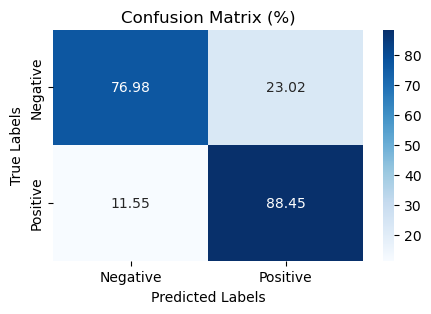

Validation Accuracy: 0.8485185185185186
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       847
           1       0.89      0.88      0.89      1853

    accuracy                           0.85      2700
   macro avg       0.82      0.83      0.83      2700
weighted avg       0.85      0.85      0.85      2700



In [109]:
# Predict on the validation set
y_val_pred = (nb_classifier.predict_proba(X_val_vec)[:, 1] >= 0.45).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Calculate percentages for each cell
cm_percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plotting the confusion matrix with percentages
plt.figure(figsize=(5, 3))
sns.heatmap(cm_percentages, annot = True, fmt = '.2f', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()

# Generate classification report for the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)
print("Validation Classification Report:")
print(val_report)

As we can see the model appears to be performing well across both classes, with a slight bias towards correctly identifying good reviews. Though we used balanced class_weight to help with this issue there appears to still be some imbalancedness here. It Correctly predicted 88% of the good reviews and 77% of the negative reviews.

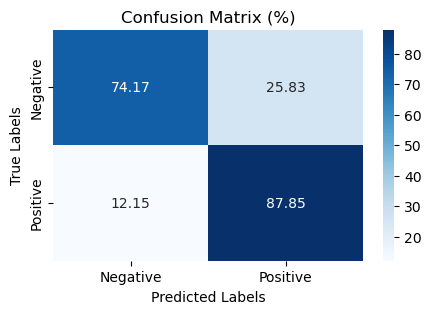

Test Accuracy: 0.8355555555555556
Test Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       848
           1       0.88      0.88      0.88      1852

    accuracy                           0.84      2700
   macro avg       0.81      0.81      0.81      2700
weighted avg       0.84      0.84      0.84      2700



In [107]:
# Predict on the test set
y_test_pred = (nb_classifier.predict_proba(X_test_vec)[:, 1] >= 0.45).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Calculate percentages for each cell
cm_percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plotting the confusion matrix with percentages
plt.figure(figsize=(5, 3))
sns.heatmap(cm_percentages, annot = True, fmt = '.2f', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()

# Generate classification report for the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)
print("Test Classification Report:")
print(test_report)

The model achieves an accuracy of 83.74% on the test set, with a slight bias toward identifying positive reviews with 87.5% correctly labled. While overall performance is good, it struggles to capture negative reviews, likely due to the dataset's imbalance, with nearly twice as many positive reviews as negative ones.

We can also look at some text the model labeled incorrectly to get an idea on what it struggled with

In [113]:
# Get predictions
y_pred_test = nb_classifier.predict(X_test_vec)

# Create a DataFrame with true labels, predicted labels, and the text
test_mismatches = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': y_pred_test,
    'Text': X_test_df['cleaned_text']
})

# Filter mismatches
incorrect_predictions = test_mismatches[test_mismatches['True_Label'] != test_mismatches['Predicted_Label']]

# Display a few examples
incorrect_predictions.head(7)

,True_Label,Predicted_Label,Text
7471,0,1,older properti clean friendli good valu close ...
51785,1,0,staff friendli long drive arriv earli day staf...
15853,1,0,nice clean complimentari breakfast averag pool...
27855,1,0,travel cheap day stay kind dump bro said would...
12522,0,1,cool concept hip crown loftstyl condo great vi...
44043,1,0,let start say want place safe clean wifi adult...
23636,0,1,great friendli staff quit slept well second ti...


The model appears to struggle with accurately distinguishing mixed sentiments in reviews. For example, it misclassifies negative reviews as positive in cases where the sentiment is somewhat positive but still includes some negatives. For instance, reviews like "older property, clean, friendly, good value, close to city center," "nice, clean, complimentary breakfast, average pool" carry mixed feelings and might indicate both positive and negative aspects. The imbalnce in the data may also have some affect on the predictions since there was twice as much good reviews than bad reviews.

Also, changing the sentiment threshold might improve the model's performance. For example, considering a rating of 3 or higher as a positive review instead of 4 or higher could possibly yield better results.